In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')

from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

import json
import gzip
from joblib import Parallel, delayed
df = pd.read_csv('../Data/USPTO_50k.csv')
display(df.head())
print(len(df))

,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...


50016


# **1. SynCleaning**

In [2]:
from SynRBL.SynCleaning import SMILESStandardizer
standardizer = SMILESStandardizer()
# Original SMILES strings for demonstration
original_smiles = [
    "C1=CC=CC=C1",  # Aromatic compound for dearomatization/aromatization
    "C1=CC=C2C(=C1)C=CC=C2",  # Tautomerizable compound
    "CC(C)(C)C(=O)O.O",  # Compound with a salt (water)
    "CC[NH+](CC)CC"  # Compound with charge
]

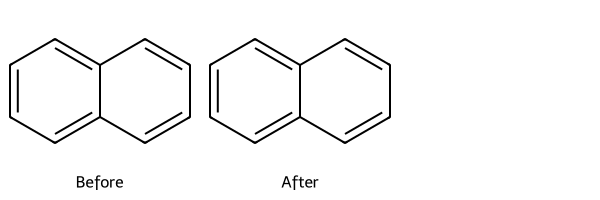

Normalized: c1ccc2ccccc2c1


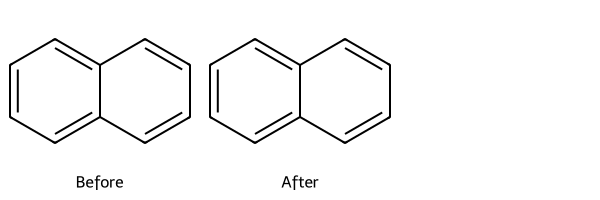

Tautomerized: c1ccc2ccccc2c1


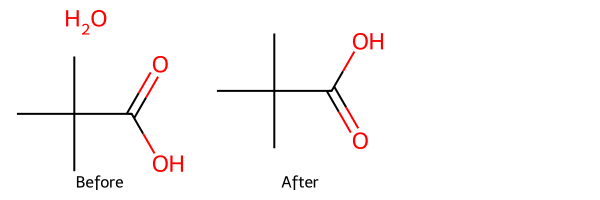

Without Salts: CC(C)(C)C(=O)O


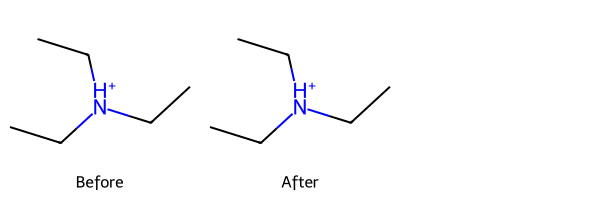

With Charges Handled: CC[NH+](CC)CC


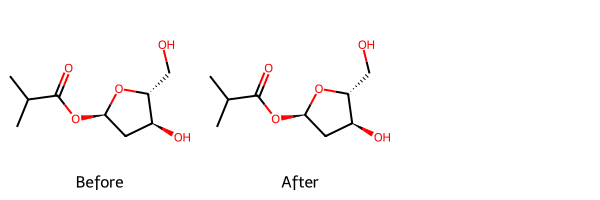

With Stereo Handled: CC(C)C(=O)O[C@@H]1C[C@H](O)[C@@H](CO)O1
Clean Radicals: CC(C)(C)C(C)(C)C
Dearomatized: c1ccccc1
Aromatized: c1ccccc1


In [3]:
# Normalize
normalized = standardizer.standardize_smiles(original_smiles[1],normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                             salt_remover=standardizer.salt_remover,normalize=True, tautomerize=False, visualize=True)
print("Normalized:", normalized)

# Tautomerize
tautomerized = standardizer.standardize_smiles(original_smiles[1],normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                             salt_remover=standardizer.salt_remover, normalize=False, tautomerize=True, visualize=True)
print("Tautomerized:", tautomerized)

# Remove Salts
without_salts = standardizer.standardize_smiles(original_smiles[2],normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                             salt_remover=standardizer.salt_remover, normalize=False, tautomerize=False, remove_salts=True,visualize=True)
print("Without Salts:", without_salts)

# Handle Charges
with_charges_handled = standardizer.standardize_smiles(original_smiles[3], normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                             salt_remover=standardizer.salt_remover,normalize=False, tautomerize=False, handle_charges=True, visualize=True)
print("With Charges Handled:", with_charges_handled)

# Handle Stereochemistry
# For stereochemistry, we need a chiral molecule. 
# Using "CC(C)C(=O)O[C@@H]1C[C@H](O)[C@@H](CO)O1" as an example
with_stereo_handled = standardizer.standardize_smiles("CC(C)C(=O)O[C@@H]1C[C@H](O)[C@@H](CO)O1",
                                                        normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                                        salt_remover=standardizer.salt_remover,
                                                        tautomerize=True,handle_stereo=True, visualize=True)
print("With Stereo Handled:", with_stereo_handled)

# Clean Radicals
# For radicals, let's use "CC(C)(C)[C](C)(C)C" as an example
# Note: The implementation of radical cleaning depends on your specific requirements
clean_radicals = standardizer.standardize_smiles("CC(C)(C)[C](C)(C)C", 
                                                    normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                                    salt_remover=standardizer.salt_remover,
                                                    clean_radicals=True)
print("Clean Radicals:", clean_radicals)

# Dearomatize
dearomatized = standardizer.standardize_smiles(original_smiles[0], 
                                                normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                                salt_remover=standardizer.salt_remover,
                                                dearomatize=True, aromatize=False)
print("Dearomatized:", dearomatized)

# Aromatize
aromatized = standardizer.standardize_smiles(original_smiles[0], 
                                            normalizer=standardizer.normalizer, tautomer=standardizer.tautomer,
                                            salt_remover=standardizer.salt_remover,
                                            dearomatize=False, aromatize=True)
print("Aromatized:", aromatized)

# **2. SynExtract**

## **2.1. Extract SMILES**

In [4]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
process=RSMIProcessing(rsmi = df.loc[0,'reactions'])
process.smi_splitter()

['COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O']

In [5]:
process=RSMIProcessing(data = df, rsmi_col='reactions',parallel=True, n_jobs=-1, save_json= True, save_path_name ='../Data/reaction.json.gz')
data = process.data_splitter()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 24576 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    2.5s finished


In [6]:
with gzip.open('../Data/reaction.json.gz') as f:
    reactions = json.load(f)

print(len(reactions))
print(reactions[0])

50016
{'id': 'US05849732', 'class': 6, 'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O', 'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O', 'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'}


## 2.2. Standardize SMILES

In [14]:
from SynRBL.SynCleaning import SMILESStandardizer
standardizer = SMILESStandardizer()

In [11]:
import warnings
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')  # Disables RDKit warnings globally

# Alternatively, you can catch warnings in a specific part of your code
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
standardizer = SMILESStandardizer()
reactions_standardized = standardizer.standardize_dict_smiles(data_input=reactions, key='reactants', visualize=False, parallel = True, n_jobs = -1,
                                                              normalizer = standardizer.normalizer, tautomer = standardizer.tautomer, 
                                                              salt_remover = standardizer.salt_remover)

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'}]

In [16]:
reactions_standardized[0]

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'standardized_reactants': 'COC(=O)C(CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'standardized_reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c

## **2.3. Molecular Decomposer**

In [7]:
from SynRBL.SynExtract import RSMIDecomposer  

In [8]:
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 40944 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 40944 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    1.8s finished


## **2.4. Molecular Comparator**

In [9]:
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import *
import pandas as pd

In [10]:
comp = RSMIComparator(reactants= react_dict, products=product_dict, n_jobs=-1)
unbalance , diff_formula= comp.run_parallel()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 45062 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 47099 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.1s finished


In [11]:
reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0:'Unbalance'}),
           pd.DataFrame([diff_formula]).T.rename(columns={0:'Diff_formula'})], axis=1).to_dict(orient='records')

reactions_clean

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 8, 'O': 2, 'H': 6}},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'Unbalance': 'Products',
  'Diff_formula': {'O': 1, 'H': 2}},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccc

In [12]:
save_database(reactions_clean, '../Data/reaction_clean.json.gz')

# **3. SynRuleEngine - Rule Generation**

## 3.1. Basic rule

In [13]:
from SynRBL.rsmi_utils import *
from SynRBL.SynRuleEngine.rule_data_manager import RuleImputeManager
reactions_clean = load_database('../Data/reaction_clean.json.gz')

In [14]:
# Test case
import pandas as pd

# Without an existing database and add one entry
db = RuleImputeManager()
try:
    db.add_entry('H2O', 'O')
except ValueError as e:
    print(e)

# With an existing list of dictionaries
existing_database = [{'formula': 'H2O', 'smiles': 'O','composition': {1: 2, 8: 1}}]
db = RuleImputeManager(existing_database)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

# With an existing pandas DataFrame
existing_dataframe = pd.DataFrame([{'formula': 'H2O', 'smiles': 'O', 'composition': {1: 2, 8: 1}}])
db = RuleImputeManager(existing_dataframe)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

# Without an existing database
db = RuleImputeManager()
entries = [{'formula': 'H2O', 'smiles': 'O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")


Entry with formula 'H2O' and smiles 'O' added to the database.
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'H2O' and smiles 'O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]


[15:02:42] SMILES Parse Error: syntax error while parsing: Invalid
[15:02:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[15:02:42] SMILES Parse Error: syntax error while parsing: Invalid
[15:02:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[15:02:42] SMILES Parse Error: syntax error while parsing: Invalid
[15:02:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


## 3.2. Inference rule

- Working to integrate rule_inference in section 4 - matching and impute

In [18]:
from SynRBL.SynRuleEngine.domain_knowledge_rules import infer_chemical_rule_for_imputation
reaction_list = []
new_reaction = infer_chemical_rule_for_imputation(rule_dict={"O":1}, smiles_reactants='[HH]', reactants_ratio=1, 
                                                  smiles_products='[OH-].[H+]', products_ratio=1, reaction_list=reaction_list)

new_reaction


[[{'rule_dict': {'O': 1},
   'smiles_reactants': '[HH]',
   'reactants_ratio': 1,
   'smiles_products': '[OH-].[H+]',
   'products_ratio': 1}]]

## 2.3. Automatic rule extraction

In [2]:
import sys
import gzip
import json
sys.path.append('../')
from SynRBL.SynRuleEngine import AutomaticSmilesExtraction, AutomaticRulesExtraction
with gzip.open('../Data/reaction.json.gz') as f:
    reactions = json.load(f)

In [4]:
# Create an instance of the AutomaticSmilesExtraction class with parallel processing
smi_extractor = AutomaticSmilesExtraction(reactions, n_jobs=-1, verbose=1)

# Example usage of get_fragments
input_dict = {
    'smiles': smi_extractor.smiles_list,
    'mw': smi_extractor.mw,
    'n_C': smi_extractor.n_C
}
filtered_fragments = AutomaticSmilesExtraction.get_fragments(input_dict, mw=100, n_C=10, combination='union')
print("Filtered Fragments:", len(filtered_fragments))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 24576 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 49136 tasks      | elapsed:    0.9s


Filtered Fragments: 3


[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.3s finished


In [6]:
extractor = AutomaticRulesExtraction(existing_database=[], n_jobs=-1, verbose=1)
extractor.add_new_entries(filtered_fragments)
rules = extractor.extract_rules()
print("Extracted Rules:", rules)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 34849 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 49739 out of 49739 | elapsed:    0.4s finished


Entry with formula 'C9H8N2' and smiles 'Nc1cccc2cnccc12' added to the database.
Entry with formula 'C10H4Cl2N2O4S2' and smiles 'O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1' added to the database.
Entry with formula 'C4H11N' and smiles 'CCNCC' added to the database.
Entry with formula 'C3H4F2O' and smiles 'O=C(CF)CF' added to the database.
Entry with formula 'C6H9ClO2' and smiles 'O=C(Cl)OC1CCCC1' added to the database.
Entry with formula 'C10H7BrN4' and smiles 'Cn1cnc(-c2cc(C#N)ccn2)c1Br' added to the database.
Entry with formula 'C9H9BN2O2' and smiles 'OB(O)c1ccc(-n2cccn2)cc1' added to the database.
Entry with formula 'C5H12N2O2' and smiles 'CC(C)(C)OC(=O)NN' added to the database.
Entry with formula 'C7H4BrClO2' and smiles 'O=C(O)c1ccc(Br)cc1Cl' added to the database.
Entry with formula 'C5H13O4P' and smiles 'CCOP(=O)(CO)OCC' added to the database.
Entry with formula 'C3H7NO2' and smiles 'COC(=O)CN' added to the database.
Entry with formula 'C4H4N2O' and smiles 'O=Cc1c[nH]cn1' added

In [82]:
len(rules)

7865

In [83]:
domain_rules = load_database('../Data/rule_manager.json.gz')
rules.extend(domain_rules)
len(rules)

7921

In [9]:
from SynRBL.rsmi_utils import remove_duplicates_by_key, sort_by_key_length
# Remove duplicates
unique_data = remove_duplicates_by_key(rules, lambda x: frozenset(x['Composition'].items()))

# Sort by length of 'Diff_formula'
auto_rules = sort_by_key_length(unique_data, lambda x: x['Composition'])
len(auto_rules)


7865

In [12]:
new_auto_rules = add_missing_key_to_dicts(auto_rules, 'Composition', 'Q', 0)
len(new_auto_rules)

7865

In [89]:
from SynRBL.rsmi_utils import save_database
save_database(auto_rules, '../Data/automatic_rules.json.gz')

# **4. SynRuleImpute**


## 4.1. Rule Matcher

In [3]:
from SynRBL.rsmi_utils import *
import pandas as pd
import numpy as np

In [14]:
data = pd.DataFrame(load_database('../Data/reaction_clean.json.gz'))
data = data[(data['Unbalance']=='Products')|(data['Unbalance']=='Reactants')]
df = pd.DataFrame(data['Diff_formula'].to_list())
df.index = data.index
df['Total missing atoms'] = df.drop(columns=['Q']).sum(axis=1)
df['Number of atomic missing'] = df.drop(columns=['Q', 'Total missing atoms']).notnull().sum(axis=1)


In [15]:
#one = data[df['Number of atomic missing']==1].to_dict('records')
test = data[(df['Number of atomic missing']<3)].to_dict('records')
Diff_formula = pd.DataFrame(test).loc[:,'Diff_formula'].to_list()
len(Diff_formula)

35055

In [16]:
rules = load_database('../Data/automatic_rules.json.gz')

In [17]:
from SynRBL.rsmi_utils import extract_atomic_elements, _get_max_comp_len, build_lookups
atomic = extract_atomic_elements(rules)
len(atomic)
max_comp_len = _get_max_comp_len(rules)
max_comp_len
lookup =build_lookups(atomic, rules)

In [19]:
# Define the test cases with their expected results
test_cases = [
    #{'Q': 0, 'H': 2, 'Expected': 'H2'},  # Should result in H2
    {'Q': 0, 'H': 2, 'O':0, 'Expected': 'H2'},  # Should result in H2
    {'O': 2, 'Expected': 'O2'},  # Should result in O2
    {'Q': 0, 'F': 2, 'Expected': 'F2'},  # Should result in F2
    {'Q': 0, 'Cl': 2, 'Expected': 'Cl2'},  # Should result in Cl2
    {'Q': 0, 'Br': 2, 'Expected': 'Br2'},  # Should result in Br2
    {'Q': 0, 'I': 2, 'Expected': 'I2'},  # Should result in I2
    {'Q': -1, 'F': 1, 'Expected': 'F-'},  # Should result in F-
    {'Q': -1, 'Cl': 1, 'Expected': 'Cl-'},  # Should result in Cl-
    {'Q': -1, 'Br': 1, 'Expected': 'Br-'},  # Should result in Br-
    {'Q': -1, 'I': 1, 'Expected': 'I-'},  # Should result in I-
    {'Q': 0, 'N': 2, 'Expected': 'N2'},  # Should result in N2
    {'Q': 1, 'H': 1, 'Expected': 'H+'},  # Should result in H+
    {'Q': -2, 'C': 1, 'O': 3, 'Expected': 'CO3--'},  # Should result in CO3--
    {'Q': -1, 'N': 1, 'H': 2, 'Expected': 'NH2-'},  # Should result in NH2-
    {'Q': -1, 'N': 1, 'O': 2, 'Expected': 'NO2-'},  # Should result in NO2-
    {'Q': -1, 'H': 1, 'S': 1, 'Expected': 'HS-'},  # Should result in HS-
    {'Q': 0, 'H': 2, 'S': 1, 'Expected': 'H2S'},  # Should result in H2S
    {'Q': 0, 'H': 2, 'S': 1, 'Expected': 'H2S'},  # Should result in H2S
    {'Q': -2, 'S': 1, 'O': 4, 'Expected': 'SO4^2-'},  # Should result in SO4^2-
    {'Q': 0, 'H': 2, 'Na': 2, 'O': 2, 'Expected': '2 NaOH'},  # Should result in 2 NaOH (Na+ and OH- examples)
    {'Q': 0, 'Li': 1, 'F': 1, 'Expected': 'Li+ and F-'},  # Should result in Li+ and F-
    {'Q': 0, 'C': 1, 'H': 4, 'Expected': 'CH4'},  # Should result in CH4
    {'Q': 1, 'N': 1, 'H': 4, 'Expected': 'NH4+'},  # Should result in NH4+
    {'Q': 0, 'C': 2, 'H': 2, 'Expected': 'C2H2'},  # Should result in C2H2
    {'Q': -1, 'C': 2, 'H': 1, 'Expected': 'C2H-'},  # Should result in C2H-
    {'Q': 0, 'C': 2, 'H': 4, 'Expected': 'C2H4'},  # Should result in C2H4
    {'Q': 0, 'C': 2, 'H': 6, 'Expected': 'C2H6'},  # Should result in C2H6
    {'Q': 0, 'C': 3, 'H': 4, 'Expected': 'C3H4'},  # Should result in C3H4
    {'Q': 0, 'C': 3, 'H': 8, 'Expected': 'C3H8'},  # Should result in C3H8
    {'Q': 0, 'C': 4, 'H': 10, 'Expected': 'nC4H10'},  # Should result in nC4H10
    {'Q': 0, 'C': 1, 'H': 4, 'Expected': 'CH4'},  # Should result in CH4
    {'Q': 0, 'C': 6, 'H': 6, 'Expected': 'C6H6'},  # Should result in C6H6
    {'Q': 0, 'C': 4, 'H': 8, 'Expected': 'C4H8'},  # Should result in C4H8
]


In [34]:
rule_dict = [
    {"formula": "H2", "smiles": "[HH]", "Composition": {"Q": 0, "H": 2}},
    {"formula": "F2", "smiles": "FF", "Composition": {"Q": 0, "F": 2}},
    {"formula": "Cl2", "smiles": "ClCl", "Composition": {"Q": 0, "Cl": 2}},
    {"formula": "Br2", "smiles": "BrBr", "Composition": {"Q": 0, "Br": 2}},
    {"formula": "I2", "smiles": "II", "Composition": {"Q": 0, "I": 2}},
    {"formula": "H+", "smiles": "[H+]", "Composition": {"Q": 1, "H": 1}},
    {"formula": "Na+", "smiles": "[Na+]", "Composition": {"Q": 1, "Na": 1}},
    {"formula": "Li+", "smiles": "[Li+]", "Composition": {"Q": 1, "Li": 1}},
    {"formula": "K+", "smiles": "[K+]", "Composition": {"Q": 1, "K": 1}},
    {"formula": "Ca2+", "smiles": "[Ca+2]", "Composition": {"Q": 2, "Ca": 1}},
    {"formula": "Mg2+", "smiles": "[Mg+2]", "Composition": {"Q": 2, "Mg": 1}},
    {"formula": "Ba2+", "smiles": "[Ba+2]", "Composition": {"Q": 2, "Ba": 1}},
    {"formula": "Al3+", "smiles": "[Al+3]", "Composition": {"Q": 3, "Al": 1}},
    {"formula": "Zn2+", "smiles": "[Zn+2]", "Composition": {"Q": 2, "Zn": 1}},
    {"formula": "Cu2+", "smiles": "[Cu+2]", "Composition": {"Q": 2, "Cu": 1}},
    {"formula": "Cu+", "smiles": "[Cu+]", "Composition": {"Q": 1, "Cu": 1}},
    {"formula": "F-", "smiles": "[F-]", "Composition": {"Q": -1, "F": 1}},
    {"formula": "Cl-", "smiles": "[Cl-]", "Composition": {"Q": -1, "Cl": 1}},
    {"formula": "Br-", "smiles": "[Br-]", "Composition": {"Q": -1, "Br": 1}},
    {"formula": "I-", "smiles": "[I-]", "Composition": {"Q": -1, "I": 1}},
    {"formula": "N2", "smiles": "N#N", "Composition": {"Q": 0, "N": 2}},
    {"formula": "O2", "smiles": "O=O", "Composition": {"Q": 0, "O": 2}},
    {"formula": "S^2-", "smiles": "[S^2-]", "Composition": {"Q": -2, "S": 1}},
    {"formula": "H2S", "smiles": "H2S", "Composition": {"Q": 0, "H":2, "S": 1}},
    {"formula": "HS-", "smiles": "[H][S-]", "Composition": {"Q": -1, "H":1, "S": 1}},
    {"formula": "OH-", "smiles": "[OH-]", "Composition": {"Q": -1, "H": 1, "O": 1}},
    {"formula": "NH3", "smiles": "N", "Composition": {"Q": 0, "H": 3, "N": 1}},
    {"formula": "NO2-", "smiles": "O=N[O-]", "Composition": {"Q": -1, "O": 2, "N": 1}},
    {"formula": "NO3-", "smiles": "[N+](=O)([O-])[O-]", "Composition": {"Q": -1, "O": 3, "N": 1}},
    {"formula": "NH2-", "smiles": "[NH2-]", "Composition": {"Q": -1, "H": 2, "N": 1}},
    {"formula": "CH4", "smiles": "C", "Composition": {"Q": 0, "H": 4, "C": 1}},
    {"formula": "C2H6", "smiles": "CC", "Composition": {"Q": 0, "H": 6, "C": 2}},
    {"formula": "C2H4", "smiles": "C=C", "Composition": {"Q": 0, "H": 4, "C": 2}},
    {"formula": "C2H2", "smiles": "C#C", "Composition": {"Q": 0, "H": 2, "C": 2}},
    {"formula": "C2H-", "smiles": "[C-]#C", "Composition": {"Q": -1, "H": 1, "C": 2}},
    {"formula": "C3H8", "smiles": "CCC", "Composition": {"Q": 0, "H": 8, "C": 3}},
    {"formula": "nC3H6", "smiles": "C=CC", "Composition": {"Q": 0, "H": 6, "C": 3}},
    {"formula": "cC3H6", "smiles": "C1CC1", "Composition": {"Q": 0, "H": 6, "C": 3}},
    {"formula": "nC4H10", "smiles": "C=CCC", "Composition": {"Q": 0, "C": 4, "H": 8}},
    {"formula": "nC4H8", "smiles": "C=C(C)C", "Composition": {"Q": 0, "C": 4, "H": 8}},
    {"formula": "iC4H10", "smiles": "CCCC", "Composition": {"Q": 0, "C": 4, "H": 10}},
    {"formula": "iC4H10", "smiles": "CC(C)C", "Composition": {"Q": 0, "C": 4, "H": 10}},
    {"formula": "C3H4", "smiles": "C#CC", "Composition": {"Q": 0, "H": 4, "C": 3}},
    {"formula": "C6H6", "smiles": "c1ccccc1", "Composition": {"Q": 0, "C": 6, "H": 6}},
    {"formula": "C7H8", "smiles": "Cc1ccccc1", "Composition": {"Q": 0, "C": 7, "H": 8}},
    {"formula": "CO2", "smiles": "O=C=O", "Composition": {"Q": 0, "C": 1, "O": 2}},
    {"formula": "[CO3]2-", "smiles": "O=C([O-])[O-]", "Composition": {"Q": -2, "C": 1, "O": 3}},
    {"formula": "SO4^2-", "smiles": "[SO4^2-]", "Composition": {"Q": -2, "S": 1, "O": 4}},
    {"formula": "NO3-", "smiles": "[NO3-]", "Composition": {"Q": -1, "N": 1, "O": 3}},
    {"formula": "PO4^3-", "smiles": "[PO4^3-]", "Composition": {"Q": -3, "P": 1, "O": 4}},
     {"formula": "CH3OH", "smiles": "CO", "Composition": {"Q": 0, "C": 1, "H": 4, "O": 1}},
    {"formula": "C2H5OH", "smiles": "CCO", "Composition": {"Q": 0, "C": 2, "H": 6, "O": 1}},
    {"formula": "CH3COO-", "smiles": "[CH3COO-]", "Composition": {"Q": -1, "C": 2, "H": 3, "O": 2}},
    {"formula": "CH3COCH3", "smiles": "CC(=O)C", "Composition": {"Q": 0, "C": 3, "H": 6, "O": 1}},
    {"formula": "CH2O", "smiles": "C=O", "Composition": {"Q": 0, "C": 1, "H": 2, "O": 1}},
    {"formula": "CH3CHO", "smiles": "CC=O", "Composition": {"Q": 0, "C": 2, "H": 4, "O": 1}},
    {"formula": "C2H6O2", "smiles": "C(CO)O", "Composition": {"Q": 0, "C": 2, "H": 6, "O": 2}},
    {"formula": "C6H5OH", "smiles": "c1ccccc1O", "Composition": {"Q": 0, "C": 6, "H": 6, "O": 1}}
]


In [20]:
from SynRBL.SynRuleImpute import SyntheticRuleMatcher

# Iterate through the test cases and execute them
for test_case in test_cases[25:30]:
    expected_result = test_case.pop('Expected', None)  # Remove 'Expected' key from the dictionary
    print(test_case)
    matcher = SyntheticRuleMatcher(rules, test_case, select='best', ranking='best')
    solution = matcher.match()
    
    print(f"Test Case: {test_case}")
    
    if expected_result is not None:
        print("Expected Result:", expected_result)
    
    print("Solution:", solution)
    print("\n")


{'Q': 0, 'C': 2, 'H': 4}
Test Case: {'Q': 0, 'C': 2, 'H': 4}
Expected Result: C2H4
Solution: [[{'smiles': 'C#C', 'Ratio': 1}, {'smiles': '[HH]', 'Ratio': 1}]]


{'Q': 0, 'C': 2, 'H': 6}
Test Case: {'Q': 0, 'C': 2, 'H': 6}
Expected Result: C2H6
Solution: [[{'smiles': 'C#C', 'Ratio': 1}, {'smiles': '[HH]', 'Ratio': 2}]]


{'Q': 0, 'C': 3, 'H': 4}
Test Case: {'Q': 0, 'C': 3, 'H': 4}
Expected Result: C3H4
Solution: [[{'smiles': 'C#CC', 'Ratio': 1}]]


{'Q': 0, 'C': 3, 'H': 8}
Test Case: {'Q': 0, 'C': 3, 'H': 8}
Expected Result: C3H8
Solution: [[{'smiles': 'C#C', 'Ratio': 1}, {'smiles': 'C', 'Ratio': 1}, {'smiles': '[HH]', 'Ratio': 1}]]


{'Q': 0, 'C': 4, 'H': 10}
Test Case: {'Q': 0, 'C': 4, 'H': 10}
Expected Result: nC4H10
Solution: [[{'smiles': 'C#C', 'Ratio': 2}, {'smiles': '[HH]', 'Ratio': 3}]]




# test zone


In [1]:
import pandas as pd
import sys
sys.path.append('../')

from SynRBL.rsmi_utils import load_database
from SynRBL.rsmi_utils import filter_data

from joblib import Parallel, delayed
from SynRBL.SynRuleImpute import SyntheticRuleImputer
rules = load_database('../Data/automatic_rules.json.gz')

reactions_clean = load_database('../Data/reaction_clean.json.gz')
filter_data = filter_data(reactions_clean, ['Reactants', 'Products'], 'Diff_formula','C', 0, 0)
print(len(filter_data))

32100


In [2]:
# tess filter_data

# For unbalance
display((pd.DataFrame(filter_data).describe(include='object')))
# For carbon
display(pd.DataFrame(pd.DataFrame(filter_data)['Diff_formula'].to_dict()).T.describe(include='all'))

,id,reactions,reactants,products,Unbalance,Diff_formula
count,32100,32100,32100,32100,32100,32100
unique,16708,31923,31897,31886,2,60
top,US20090221555A1,BrCc1ccccc1.Oc1ccc(Br)cc1F>>Fc1cc(Br)ccc1OCc1c...,BrCc1ccccc1.Oc1ccc(Br)cc1F,Cc1cccc(C2CC2)c1Oc1nnc(Cl)cc1O,Products,"{'Cl': 1, 'H': 1}"
freq,64,3,3,4,30334,9556


,O,H,Cl,Br,B,F,Q,I,Cu,S,N,Zn,Mg
count,12405.000000,29416.000000,10302.000000,6285.000000,1850.0,997.0,814.000000,1771.000000,62.0,25.0,73.000000,67.0,46.0
mean,1.171624,1.500680,1.005436,1.013683,1.0,1.0,-0.466830,1.011858,1.0,1.0,1.342466,1.0,1.0
std,0.380898,0.667142,0.073531,0.116182,0.0,0.0,0.884891,0.108276,0.0,0.0,0.477818,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.0,1.0,-1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.0,1.0,-1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
50%,1.000000,1.000000,1.000000,1.000000,1.0,1.0,-1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0
75%,1.000000,2.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,2.000000,1.0,1.0
max,3.000000,8.000000,2.000000,2.000000,1.0,1.0,1.000000,2.000000,1.0,1.0,2.000000,1.0,1.0


In [5]:
import logging
import sys
from rdkit import Chem
import rdkit
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
# Create a log file to redirect the warnings
#log_file = 'rdkit_warnings.log'

#logging.basicConfig(filename=log_file, level=logging.WARNING)

# Redirect warnings to the log file
rdkit_logger = logging.getLogger('rdkit')
rdkit_logger.addHandler(logging.StreamHandler(sys.stdout))

# Suppress RDKit warnings in the console
rdkit_logger.setLevel(logging.ERROR)

# Your code goes here

# Suppress RDKit warnings
rdkit.RDLogger.DisableLog('rdApp.*')
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')
new = imp.parallel_impute(filter_data)

# Close the log file when you're done
#logging.shutdown()


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 334 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done 834 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-2)]: Done 1534 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done 2822 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-2)]: Done 5022 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-2)]: Done 7622 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-2)]: Done 10622 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 14022 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 17822 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 22022 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 26622 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done 31622 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-2)]: Done 32079 out of 32100 | elapsed:  3.4min remaining:    0.1s
[Parallel(n_jobs

In [23]:
from SynRBL.rsmi_utils import save_database
import json
save_database(new,'../Data/non_C.json')

# Stop here

## 4.2. Rule Imputation

In [12]:
from SynRBL.SynRuleImpute import SyntheticRuleMatcher, SyntheticRuleImputer

In [31]:
imp = SyntheticRuleImputer(rule_dict=rules)
dict_impute=imp.impute(missing_dict=reactions_clean[30:32])
dict_impute

IndexError: list index out of range

In [40]:
df_test = pd.DataFrame(reactions_clean)
df_test[(df_test['Unbalance']=='Products') | (df_test['Unbalance']=='Reactions')]

,id,class,reactions,reactants,products,Unbalance,Diff_formula
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,Products,"{'C': 8, 'O': 2, 'H': 6}"
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,Products,"{'O': 1, 'H': 2}"
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,Products,{'O': 1}
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,Products,{'O': 1}
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,Products,"{'Cl': 1, 'H': 1}"
...,...,...,...,...,...,...,...
50009,US20120065257A1,9,BrCC1COc2ccccc2O1.[C-]#N>>N#CCC1COc2ccccc2O1,BrCC1COc2ccccc2O1.[C-]#N,N#CCC1COc2ccccc2O1,Products,"{'Br': 1, 'Q': -1}"
50010,US20090028925A1,9,BrC(Br)(Br)Br.COCOc1ccc(Cc2c(C)cc(CO)cc2C)cc1C...,BrC(Br)(Br)Br.COCOc1ccc(Cc2c(C)cc(CO)cc2C)cc1C...,COCOc1ccc(Cc2c(C)cc(CBr)cc2C)cc1Cc1ccc(F)cc1,Products,"{'Br': 3, 'C': 1, 'O': 1, 'H': 1}"
50011,US20140194411A1,9,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3,Products,{'O': 1}
50012,US20090149445A1,9,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu]>>N...,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,Products,"{'Br': 1, 'Cu': 1}"


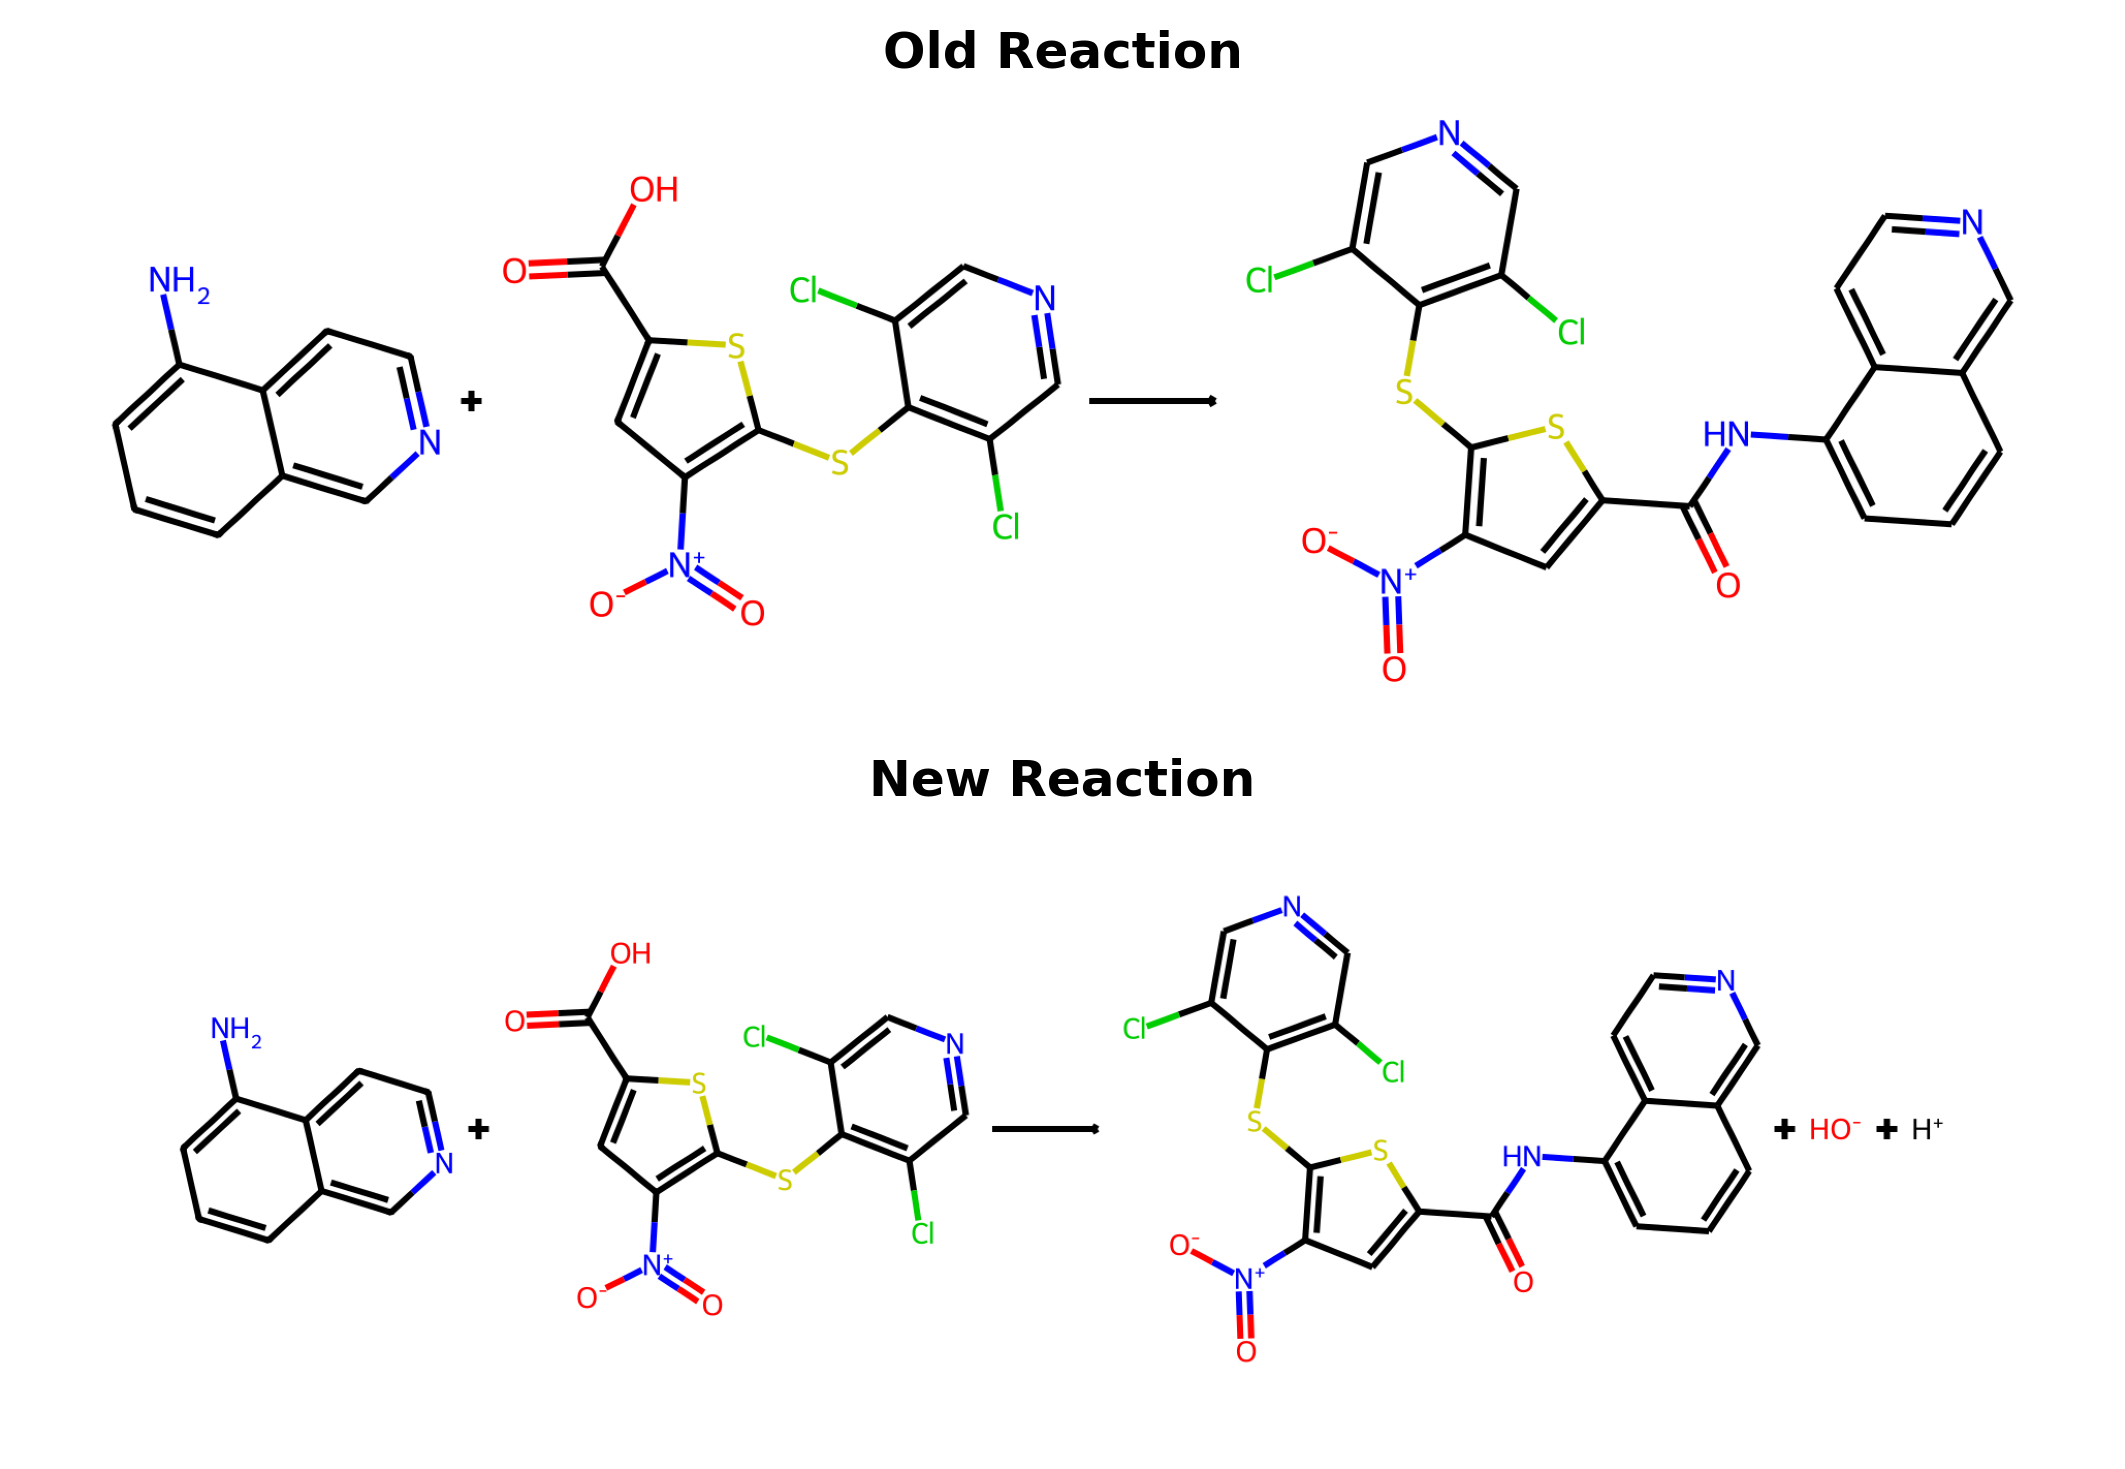

In [46]:
from SynRBL.SynVis import ReactionVisualizer

vis = ReactionVisualizer()
vis.plot_reactions(old_reaction_str=dict_impute[0]['reactions'], new_reaction_str=dict_impute[0]['new_reaction'], 
                   savefig=True, pathname = './Image/Reaction.png', dpi = 600)

## 4.3. Postprocessing 

### 4.3.1. FormulaSimilarityFinder

In [1]:
from SynRBL.SynRuleImpute import FormulaSimilarityFinder

In [2]:
# Example usage
pen = {'formula': 'C5H12O', 'smiles': 'CCCCCO'}
spen = {'formula': 'C5H12O', 'smiles': 'CCCC(O)C'}
pen_3 = {'formula': 'C5H12O', 'smiles': 'CCC(O)CC'}
tpen = {'formula': 'C5H12O', 'smiles': 'CC(O)(C)CC'}
ipen = {'formula': 'C5H12O', 'smiles': 'CC(C)CCO'}
neopen = {'formula': 'C5H12O', 'smiles': 'CC(C)(C)CO'}
ref_smiles = 'CC(C)CCOC(C)=O'

hit_molecules = [pen, spen, pen_3, tpen, ipen, neopen]
fingerprint_types = ['ecfp4', 'rdk5', 'maccs', 'map4', 'avalon']

similarity_calculator = FormulaSimilarityFinder(ref_smiles, hit_molecules)
most_similar_molecule = similarity_calculator.get_most_similar_molecule(fingerprint_types, 'hard')
print("Most similar molecule:", most_similar_molecule)


Most similar molecule: {'formula': 'C5H12O', 'smiles': 'CC(C)CCO'}


### 4.3.2. MCSfinder

In [31]:
from SynRBL.SynRuleImpute import MCSFinder

In [32]:
# Example usage
ref_smiles = 'CC(C)CCOC(C)=O'
hit_molecules = [
    {'formula': 'C5H12O', 'smiles': 'CCCCCO'},
    {'formula': 'C5H12O', 'smiles': 'CCCC(O)C'},
    {'formula': 'C5H12O', 'smiles': 'CCC(O)CC'},
    {'formula': 'C5H12O', 'smiles': 'CC(O)(C)CC'},
    {'formula': 'C5H12O', 'smiles': 'CC(C)CCO'},
    {'formula': 'C5H12O', 'smiles': 'CC(C)(C)CO'}
]

mcs_finder = MCSFinder(ref_smiles)

# RDKit's native MCS method
print("RDKit's native MCS method:")
for hit_molecule in hit_molecules:
    mcs_info = mcs_finder.get_mcs_info(hit_molecule['smiles'])
    print(f"RDKit MCS with {hit_molecule['smiles']}: Size = {mcs_info['size']}, SMILES = {mcs_info['smiles']}")

# Graph-based approach with RDKit's molecule-to-graph conversion
print("\nGraph-based approach with RDKit's molecule-to-graph conversion:")
for hit_molecule in hit_molecules:
    mcs_info = mcs_finder.get_mcs_info(hit_molecule['smiles'], use_graph=True)
    print(f"Graph MCS with {hit_molecule['smiles']} using RDKit: Size = {mcs_info['size']}")

# Graph-based approach with pysmiles, ignoring atom and bond types
print("\nGraph-based approach with pysmiles, ignoring atom and bond types:")
for hit_molecule in hit_molecules:
    mcs_info = mcs_finder.get_mcs_info(hit_molecule['smiles'], use_graph=True, use_pysmiles=True)
    print(f"Graph MCS with {hit_molecule['smiles']} using pysmiles: Size = {mcs_info['size']}")

RDKit's native MCS method:
RDKit MCS with CCCCCO: Size = 5, SMILES = [#6]-[#6]-[#6]-[#6]-[#8]
RDKit MCS with CCCC(O)C: Size = 5, SMILES = [#6]-[#6]-[#6]-[#6]-[#8]
RDKit MCS with CCC(O)CC: Size = 4, SMILES = [#6]-[#6]-[#6]-[#8]
RDKit MCS with CC(O)(C)CC: Size = 5, SMILES = [#6]-[#6](-[#6])-[#6]-[#6]
RDKit MCS with CC(C)CCO: Size = 6, SMILES = [#6]-[#6](-[#6])-[#6]-[#6]-[#8]
RDKit MCS with CC(C)(C)CO: Size = 4, SMILES = [#6]-[#6](-[#6])-[#6]

Graph-based approach with RDKit's molecule-to-graph conversion:
Graph MCS with CCCCCO using RDKit: Size = 0
Graph MCS with CCCC(O)C using RDKit: Size = 0
Graph MCS with CCC(O)CC using RDKit: Size = 0
Graph MCS with CC(O)(C)CC using RDKit: Size = 0
Graph MCS with CC(C)CCO using RDKit: Size = 6
Graph MCS with CC(C)(C)CO using RDKit: Size = 0

Graph-based approach with pysmiles, ignoring atom and bond types:
Graph MCS with CCCCCO using pysmiles: Size = 0
Graph MCS with CCCC(O)C using pysmiles: Size = 0
Graph MCS with CCC(O)CC using pysmiles: Size = 0
G

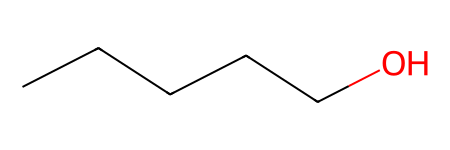

In [2]:
from rdkit import Chem
Chem.MolFromSmiles('CCCCCO')

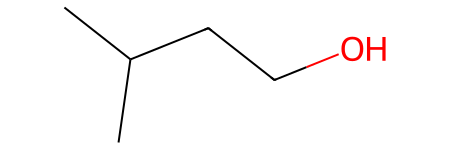

In [3]:
Chem.MolFromSmiles('CC(C)CCO')